In [1]:
import importlib
import os
import more_itertools

#plotting imports
from tkinter import CENTER
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

# Pokemon Battle Predictor
### By Greeley Lindbergh and Emily Inkrott

## Introduction
*This section must briefly describe the dataset you used and the classification task you implemented (e.g., what were you trying to classify in the dataset). You should also briefly describe your findings (e.g., what classifier approach performed the best).*

For our project, we worked with a **Pokemon battle dataset**. Looking at a list of Pokemon matchups, **we attempted to determine which Pokemon would win the battle** based on their individual charictaristics, similar to the PA7 basketball classification task.

## Data Analysis

Our dataset initially consisted of three different csv files: `combats.csv`, which had a list of matchups between two pokemon and the winner for each battle, `pokemon.csv`, which listed information on every pokemon in `combats.csv`, and a third csv file containing a testing set, which was not used in the project. We combined `pokemon.csv` and `combats.csv` into `pokemon_combats.csv` for our exploratory data analysis and inital classifier performance analysis. Later, we decided that calculating advantages would give us better results than using individual stat values, leading to the creation of `pokemon_combats_advantage.csv`.

**Our dataset has 50,000 instances and 19 attributes**.

The following attributes are in `pokemon_combats_advantage.csv`:
1. **First_pokemon**: the ID number of the first battler
2. **Name_first**: the name of the first battler
3. **Type_1_first**: the primary type of the first battler
4. **Type_2_first**: the primary type of the second battler
5. **Generation_first**: the generation of Pokemon games that the first battler was introduced in
6. **Legendary_first**: whether or not the first battler is a legendary Pokemon
7. **Second_pokemon, Name_second, Type 1_second, Type 2_second, Generation_second, Legendary_second**, which are all the same as their "first" counterparts, but for the second battler
8. **HP**: which Pokemon has the higher HP stat (either 1 or 2)
9. **Attack**: which Pokemon has the higher attack stat (either 1 or 2)
10. **Defense**: which Pokemon has the higher defense stat (either 1 or 2)
10. **Sp. Atk**: which Pokemon has the higher special attack stat (either 1 or 2)
10. **Sp. Def**: which Pokemon has the higher special defense stat (either 1 or 2)
10. **Speed**: which Pokemon has the higher speed stat (either 1 or 2)
10. **Winner**: which Pokemon won the battle. **This is our class label.**

In [3]:
filename = os.path.join("input_data", "pokemon_combats.csv")
combats_filename = os.path.join("input_data", "combats.csv")
pokemon_filename = os.path.join("input_data", "pokemon.csv")

pokemon_table = MyPyTable().load_from_file(pokemon_filename)
combats_filename = MyPyTable().load_from_file(combats_filename)
table = MyPyTable().load_from_file(filename)



27


During our initial EDA, we looked at several attributes to see how they might correlate with win rates. **We discovered two main indicators of who would win the battle: type, and speed.** These charts can be found in `EDA.ipynb` and have been reproduced below. 

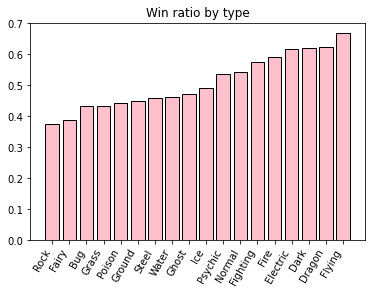

In [7]:
primary_type_vals, primary_type_counts = myutils.get_frequencies_by_col_name(pokemon_table.data, pokemon_table.column_names, "Type 1")
secondary_type_vals, secondary_type_counts = myutils.get_frequencies_by_col_name(pokemon_table.data, pokemon_table.column_names, "Type 2")

#add frequencies to get the total number of apperances by type
for i in range(len(secondary_type_vals)):
    if secondary_type_vals[i] in primary_type_vals:
        p_index = primary_type_vals.index(secondary_type_vals[i])
        primary_type_counts[p_index] += secondary_type_counts[i]


s_counts, s_types = more_itertools.sort_together([primary_type_counts, primary_type_vals])

winners = []
losers = []
type_counts = [0 for instance in s_types]
type_indexes = [5, 6, 17, 18]
winners_header = pokemon_table.column_names.copy()
for instance in table.data:
    curr_winner = []
    curr_loser = []
    if instance[2] == 1:
        curr_winner.extend(instance[3:15])
        curr_loser.extend(instance[15:])
    else:
        curr_winner.extend(instance[15:])
        curr_loser.extend(instance[3:15])
    winners.append(curr_winner)
    losers.append(curr_loser)
    #types are stored at 5, 6, 17, 18 
    for index in type_indexes:
        type = instance[index]
        if type != '':
            type_counts[s_types.index(type)] += 1

winner_type_vals, winner_type_counts = myutils.get_frequencies_by_col_name(winners, winners_header, "Type 1")
w_secondary_type_vals, w_secondary_type_counts = myutils.get_frequencies_by_col_name(winners, winners_header, "Type 2")

#add frequencies to get the total number of apperances by type
for i in range(len(w_secondary_type_vals)):
    if w_secondary_type_vals[i] in winner_type_vals:
        p_index = winner_type_vals.index(w_secondary_type_vals[i])
        winner_type_counts[p_index] += w_secondary_type_counts[i]
w_ratios = []
for i in range(len(winner_type_vals)):
    #s_types parallel to type_counts
    w_ratios.append(winner_type_counts[i]/type_counts[s_types.index(winner_type_vals[i])])

w_rates, w_types, w_counts = more_itertools.sort_together([w_ratios, winner_type_vals, winner_type_counts])

plt.figure()
plt.bar(w_types, w_rates, align= CENTER, edgecolor='black', color = 'pink')
plt.xticks(w_types, w_types, rotation = 60, ha="right")
plt.title("Win ratio by type")
plt.show()

Different types had win ratios varying by as much as 30%. **Dragon, Flying, and Dark types had the highest win ratios, while Rock, Fairy, and Bug types had the lowest.**

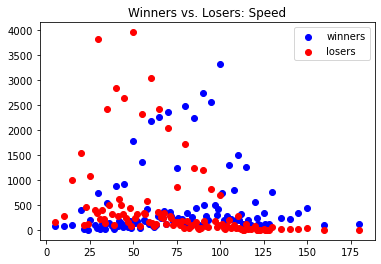

In [9]:
stat_header = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
stat_table = myutils.get_columns(winners, winners_header, stat_header)
loser_stat_table =  myutils.get_columns(losers, winners_header, stat_header)
    
stat_vals, stat_freqs = myutils.get_frequencies_by_col_name(stat_table, stat_header, "Speed")
loser_vals, loser_freqs = myutils.get_frequencies_by_col_name(loser_stat_table, stat_header, "Speed")
plt.title("Winners vs. Losers: Speed")
plt.scatter(stat_vals, stat_freqs, color="blue", label="winners")
plt.scatter(loser_vals, loser_freqs, color="red", label="losers")
plt.legend()
plt.show()

Speed was the only stat that showed significant differences between battle winners and losers. **Battle winners noticeably tended to have a higher speed stat, while battle losers had lower ones.** Attack and special defense also had slight variation where winners tended to have higher stats than losers, but the difference was far less significant.